# Learning to Learn on Fashion MNIST dataset
### Train For Epochs instead of per steps as original paper describes

### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tqdm import tqdm
import tensorflow_datasets as tfds
import sklearn.metrics as sm
from matplotlib import pyplot as plt

### Default LSTM optimizer parameters

In [ ]:
n_parameters = 4 # 2 dense layers and 2 biases
batch_size = 128
num_unroll = 20
hidden_size = 20
num_layers = 3
epochs = 50

### Retrieve and prepare data

In [ ]:
(train_data, validation_data), info = tfds.load("fashion_mnist", split=['train[:90%]', 'train[90%:]'], with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

train_data = train_data.map(format_image)
validation_data = validation_data.map(format_image)

test_data = test_data.map(format_image)

In [ ]:
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
test_x, test_y = tuple(zip(*test_data))

test_x = np.array(test_x)
test_y = np.array(test_y)

valid_x, valid_y = tuple(zip(*validation_data))

valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

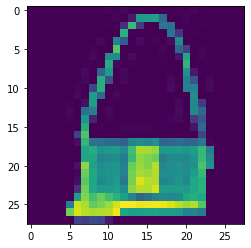

In [ ]:
plt.imshow(valid_x[3].reshape(28,28))
plt.show()

In [ ]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
test_val_accuracy = val_accuracy = sm.accuracy_score
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

### Define custom layers to allow gradient flow

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, activation=None):
        '''Initializes the instance attributes'''
        super(CustomDense, self).__init__()
        self.units = units
        # define the activation to get from the built-in activation layers in Keras
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.initializers.GlorotUniform()
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs, weights, bias):
        '''Defines the computation from inputs to outputs'''

        return self.activation(tf.matmul(inputs, weights) + bias)

In [ ]:
class MnistOptimizee(Model):
    def __init__(self):
        super(MnistOptimizee, self).__init__()
        # Now we initalize the needed layers - order does not matter.
        # -----------------------------------------------------------
        # Flatten Layer
        self.flatten = tf.keras.layers.Flatten()
        # First Dense Layer
        self.dense1 = CustomDense(20, activation='tanh')
        # Output Layer
        self.dense2 = CustomDense(10, activation='softmax')
                        
        # keep track of training losses
        self.training_losses, self.validation_losses = [], []
        self.tensor_trainable_weights = self.trainable_weights
    
    def call(self, inputs, tensor_trainable_weights):
        x = self.flatten(inputs)        
        x = self.dense1(x, tensor_trainable_weights[0], tensor_trainable_weights[1])
        classifier = self.dense2(x, tensor_trainable_weights[2], tensor_trainable_weights[3])
        return classifier


### Define methods to train LSTM optimizer and optimizee network

In [ ]:
# Train Optimizer
def train_optimizer(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data, for_optimizer=True)
        model.training_losses.append(loss.numpy())
        model.validation_losses.append(val_loss)
        print("\n Epoch: {} , loss: {} val_loss: {} val_acc: {} \n".format(epoch, loss, val_loss, val_acc))


def train_data_for_one_epoch(train_data, for_optimizer=False): 
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    avg_validation_loss = 0
    avg_validation_accuracy = 0
    avg_loss = 0

    for step, (x_batch_train, y_batch_train) in enumerate(train):
        if for_optimizer:
          loss = apply_optimizer_gradient(x_batch_train, y_batch_train)
        else:
          loss = apply_gradient(x_batch_train, y_batch_train)

        avg_loss += loss

        # validation dataset
        validation_predictions = model(valid_x, model.tensor_trainable_weights)
        validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)
        avg_validation_loss += validation_loss

        # Take the max value after prediction for accuracy metric
        validation_predictions = np.argmax(validation_predictions, axis=1) 
        validation_accuracy = val_accuracy(y_true=valid_y, y_pred=validation_predictions)
        avg_validation_accuracy += validation_accuracy 
        pbar.set_description("Training loss for step %s: %.4f val_loss %.4f val_acc %.3f" % (
            int(step), float(loss), float(validation_loss), float(validation_accuracy)
        ))
        pbar.update()

    avg_loss /= 424 # items per batches
    avg_validation_loss /= 424
    avg_validation_accuracy /= 424
    return avg_loss, avg_validation_loss, avg_validation_accuracy


def apply_optimizer_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    losses = []
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)

        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch(model.tensor_trainable_weights)

                predictions = model(x_batch_train, model.tensor_trainable_weights)  
                loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
              
                losses.append(loss_value)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                              for i in range(len(model.tensor_trainable_weights))]

        
        losses = tf.reduce_sum(losses)
        
        # calculate the loss against all losses of the optimizee
        lstm_gradients = tape_master.gradient(losses, LSTM_optimizer.trainable_weights)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 0.3)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    # calculate average loss
    losses /= LSTM_optimizer.num_unroll
    return losses

In [ ]:
# Training the model
def initialize_model():
    model.dense1.build((128, 784)) # input data after flatten (28*28)
    model.dense2.build((128, 20))
    model.tensor_trainable_weights = model.trainable_weights

def train_model(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data)
        model.training_losses.append(loss.numpy())
        model.validation_losses.append(val_loss)
        print("\n Epoch: {} , loss: {} val_loss: {} val_acc: {} \n".format(epoch, loss, val_loss, val_acc))


def apply_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0

    with tf.GradientTape() as tape:
        tape.watch(model.tensor_trainable_weights)

        predictions = model(x_batch_train, model.tensor_trainable_weights)  
        loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

        gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      
        loss = loss_value
        # Retrieve new results from optimizer
        lstm_optimizer_results = LSTM_optimizer(gradients) 
        # update trainable weights based on the optimer change for that step
        model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                          for i in range(len(model.tensor_trainable_weights))]

    return loss

### Define LSTM Optimizer

In [ ]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, n_parameters, batch_size, num_unroll, preprocessing_value=10,**kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        #, recurrent_regularizer=reg
        self.batches = [15680, 20, 200, 10]
        self.lstm_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size, kernel_regularizer=tf.keras.regularizers.l2(l2=0.02)) for i in range(num_layers)])
        self.state_list = [self.lstm_cells.get_initial_state(batch_size = self.batches[i], dtype = 'float') for i in range(n_parameters)]
        self.num_unroll = num_unroll
        self.preprocessing_value = preprocessing_value 
        
    def refresh_state(self): 
        self.state_list = [self.lstm_cells.get_initial_state(batch_size = self.batches[i], dtype = 'float') for i in range(n_parameters)]
    
    def call(self, gradients):
        parameter_updates = []
        for i in range(n_parameters):
            grad_h_t = gradients[i]  # The gradient of the i-th parameter
            state = self.state_list[i]
            
            try:
                grad_h_t.shape[1] # check if the tensor is 2D as this is what the cell() accepts
            except:
                grad_h_t = tf.reshape(grad_h_t, [model.variables[i].shape[0], 1]) # make tensor 2D which is compatible with cell call function 
            
            flattened_grad = tf.reshape(grad_h_t,[-1, ]) # flatten out the gradient to make it compatible with the cell
            # Preprocessing
            preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

            condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
            case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
            case_false1 = -1
            preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

            case_true2 = np.sign(flattened_grad)
            case_false2 = np.exp(self.preprocessing_value) * flattened_grad
            preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)

            cell_output, state = self.lstm_cells(preprocessed_inputs, state)
            self.state_list[i] = state # update the state
            cell_output = self.batch_norm(cell_output)
            parameter_update = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 

            parameter_update = tf.reshape(parameter_update, [grad_h_t.shape[0], grad_h_t.shape[1]]) # reshape the update back to the dimension of the gradients
            parameter_update = parameter_update * 0.05 # rescale as paper mentions 
            parameter_updates.append(parameter_update)
        
        parameter_updates[1] = tf.squeeze(parameter_updates[1]) # biases
        parameter_updates[3] = tf.squeeze(parameter_updates[3]) # biases

        return parameter_updates

### Train Optimizer and Optimizee networks


In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=hidden_size, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [ ]:
model = MnistOptimizee()
initialize_model()

In [ ]:
train_optimizer(train, epochs=5)

Training loss for step 421: 0.2924 val_loss 0.8808 val_acc 0.755: 100%|██████████| 422/422 


 Epoch: 0 , loss: 0.5452629327774048 val_loss: 0.7818145155906677 val_acc: 0.7396222484276727 



Training loss for step 421: 0.9338 val_loss 1.1493 val_acc 0.654: 100%|██████████| 422/422 


 Epoch: 1 , loss: 0.6607288122177124 val_loss: 0.9567298293113708 val_acc: 0.7020349842767291 



Training loss for step 421: 1.0612 val_loss 1.2157 val_acc 0.637: 100%|██████████| 422/422 


 Epoch: 2 , loss: 0.897367537021637 val_loss: 1.1524425745010376 val_acc: 0.6376029874213832 



Training loss for step 421: 0.7785 val_loss 1.2957 val_acc 0.643: 100%|██████████| 422/422 


 Epoch: 3 , loss: 0.9081683158874512 val_loss: 1.1703777313232422 val_acc: 0.6390691823899373 



Training loss for step 421: 0.9644 val_loss 1.2596 val_acc 0.586: 100%|██████████| 422/422 


 Epoch: 4 , loss: 1.004660725593567 val_loss: 1.261655569076538 val_acc: 0.616685534591195 



In [ ]:
# Initalize model and use trained optimizer to train the optimizee
model = MnistOptimizee()
initialize_model()

In [ ]:
train_model(train, epochs=epochs)

Training loss for step 421: 0.3425 val_loss 0.4915 val_acc 0.821: 100%|█████████▉| 421/422 


 Epoch: 0 , loss: 0.6320686340332031 val_loss: 0.62116938829422 val_acc: 0.772163522012578 



Training loss for step 421: 0.5162 val_loss 0.4464 val_acc 0.839: 100%|█████████▉| 421/422 


 Epoch: 1 , loss: 0.4616236686706543 val_loss: 0.4618655741214752 val_acc: 0.8269335691823901 



Training loss for step 421: 0.5434 val_loss 0.3925 val_acc 0.861: 100%|█████████▉| 421/422 


 Epoch: 2 , loss: 0.42688941955566406 val_loss: 0.43003106117248535 val_acc: 0.8383128930817618 



Training loss for step 421: 0.5038 val_loss 0.4159 val_acc 0.853: 100%|█████████▉| 421/422 


 Epoch: 3 , loss: 0.40724635124206543 val_loss: 0.41363003849983215 val_acc: 0.8445192610062895 



Training loss for step 421: 0.3391 val_loss 0.4066 val_acc 0.855: 100%|█████████▉| 421/422 


 Epoch: 4 , loss: 0.3987528383731842 val_loss: 0.4067882299423218 val_acc: 0.848108490566037 



Training loss for step 421: 0.3499 val_loss 0.3954 val_acc 0.858: 100%|█████████▉| 421/422 


 Epoch: 5 , loss: 0.3896446228027344 val_loss: 0.4015105664730072 val_acc: 0.8500113993710685 



Training loss for step 421: 0.3133 val_loss 0.4174 val_acc 0.856: 100%|█████████▉| 421/422 


 Epoch: 6 , loss: 0.38043490052223206 val_loss: 0.39718058705329895 val_acc: 0.8517169811320754 



Training loss for step 421: 0.2665 val_loss 0.3899 val_acc 0.859: 100%|██████████| 422/422 


 Epoch: 7 , loss: 0.3769267499446869 val_loss: 0.39402100443840027 val_acc: 0.8533832547169814 



Training loss for step 421: 0.3336 val_loss 0.3905 val_acc 0.859: 100%|█████████▉| 421/422 


 Epoch: 8 , loss: 0.37239161133766174 val_loss: 0.39028507471084595 val_acc: 0.8544944968553464 



Training loss for step 421: 0.3906 val_loss 0.4034 val_acc 0.856: 100%|█████████▉| 421/422 


 Epoch: 9 , loss: 0.36677029728889465 val_loss: 0.3897973597049713 val_acc: 0.8548297955974848 



Training loss for step 421: 0.5188 val_loss 0.3916 val_acc 0.857: 100%|██████████| 422/422 


 Epoch: 10 , loss: 0.36536338925361633 val_loss: 0.39231595396995544 val_acc: 0.8540432389937105 



Training loss for step 421: 0.2744 val_loss 0.4053 val_acc 0.858: 100%|█████████▉| 421/422 


 Epoch: 11 , loss: 0.3629019260406494 val_loss: 0.39003440737724304 val_acc: 0.855213836477987 



Training loss for step 421: 0.3054 val_loss 0.3932 val_acc 0.858: 100%|█████████▉| 421/422 


 Epoch: 12 , loss: 0.3606669306755066 val_loss: 0.3917519450187683 val_acc: 0.8547000786163524 



Training loss for step 421: 0.2709 val_loss 0.3966 val_acc 0.858: 100%|██████████| 422/422 


 Epoch: 13 , loss: 0.356658011674881 val_loss: 0.39071589708328247 val_acc: 0.8554846698113205 



Training loss for step 421: 0.2415 val_loss 0.4002 val_acc 0.861: 100%|█████████▉| 421/422 


 Epoch: 14 , loss: 0.3562367558479309 val_loss: 0.3922339677810669 val_acc: 0.8546022012578617 



Training loss for step 421: 0.3727 val_loss 0.4100 val_acc 0.855: 100%|█████████▉| 421/422 


 Epoch: 15 , loss: 0.353649765253067 val_loss: 0.39158201217651367 val_acc: 0.8545998427672962 



Training loss for step 421: 0.3766 val_loss 0.4039 val_acc 0.857: 100%|█████████▉| 421/422 


 Epoch: 16 , loss: 0.35328420996665955 val_loss: 0.39178571105003357 val_acc: 0.8553844339622638 



Training loss for step 421: 0.3910 val_loss 0.3927 val_acc 0.861: 100%|█████████▉| 421/422 


 Epoch: 17 , loss: 0.3530701994895935 val_loss: 0.3907037675380707 val_acc: 0.8564929245283022 



Training loss for step 421: 0.4027 val_loss 0.4116 val_acc 0.852: 100%|█████████▉| 421/422 


 Epoch: 18 , loss: 0.34880831837654114 val_loss: 0.3910938799381256 val_acc: 0.8563101415094331 



Training loss for step 421: 0.2545 val_loss 0.4459 val_acc 0.849: 100%|█████████▉| 421/422 


 Epoch: 19 , loss: 0.35055050253868103 val_loss: 0.39192959666252136 val_acc: 0.8563805031446547 



Training loss for step 421: 0.2995 val_loss 0.3969 val_acc 0.857: 100%|█████████▉| 421/422 


 Epoch: 20 , loss: 0.3497313857078552 val_loss: 0.3952120542526245 val_acc: 0.8558062106918247 



Training loss for step 421: 0.4700 val_loss 0.4101 val_acc 0.856: 100%|█████████▉| 421/422 


 Epoch: 21 , loss: 0.3498501181602478 val_loss: 0.39384835958480835 val_acc: 0.8562889150943396 



Training loss for step 421: 0.4057 val_loss 0.3937 val_acc 0.864: 100%|█████████▉| 421/422 


 Epoch: 22 , loss: 0.3483661115169525 val_loss: 0.3939293920993805 val_acc: 0.8568180031446543 



Training loss for step 421: 0.3198 val_loss 0.3937 val_acc 0.862: 100%|██████████| 422/422 


 Epoch: 23 , loss: 0.34766387939453125 val_loss: 0.39415407180786133 val_acc: 0.8569308176100633 



Training loss for step 421: 0.2480 val_loss 0.3951 val_acc 0.858: 100%|█████████▉| 421/422 


 Epoch: 24 , loss: 0.34553661942481995 val_loss: 0.39472290873527527 val_acc: 0.8565715408805039 



Training loss for step 421: 0.2063 val_loss 0.4173 val_acc 0.857: 100%|█████████▉| 421/422 


 Epoch: 25 , loss: 0.3456711173057556 val_loss: 0.39592209458351135 val_acc: 0.8561084905660383 



Training loss for step 421: 0.3419 val_loss 0.3995 val_acc 0.861: 100%|██████████| 422/422 


 Epoch: 26 , loss: 0.3462141752243042 val_loss: 0.39609402418136597 val_acc: 0.8564048742138377 



Training loss for step 421: 0.4369 val_loss 0.4080 val_acc 0.860: 100%|█████████▉| 421/422 


 Epoch: 27 , loss: 0.34603920578956604 val_loss: 0.39525553584098816 val_acc: 0.8571041666666668 



Training loss for step 421: 0.3500 val_loss 0.4015 val_acc 0.858: 100%|█████████▉| 421/422 


 Epoch: 28 , loss: 0.34402844309806824 val_loss: 0.3964342176914215 val_acc: 0.8563046383647804 



Training loss for step 421: 0.3495 val_loss 0.3953 val_acc 0.857: 100%|█████████▉| 421/422 


 Epoch: 29 , loss: 0.34405601024627686 val_loss: 0.39615997672080994 val_acc: 0.8555927672955975 



Training loss for step 421: 0.3452 val_loss 0.4143 val_acc 0.860: 100%|█████████▉| 421/422 


 Epoch: 30 , loss: 0.3441261053085327 val_loss: 0.39816543459892273 val_acc: 0.8556584119496856 



Training loss for step 421: 0.3552 val_loss 0.4105 val_acc 0.860: 100%|█████████▉| 421/422 


 Epoch: 31 , loss: 0.34168151021003723 val_loss: 0.39967015385627747 val_acc: 0.8549544025157226 



Training loss for step 421: 0.2965 val_loss 0.4083 val_acc 0.855: 100%|█████████▉| 421/422 


 Epoch: 32 , loss: 0.34233561158180237 val_loss: 0.40151160955429077 val_acc: 0.8547193396226418 



Training loss for step 421: 0.2882 val_loss 0.4085 val_acc 0.858: 100%|█████████▉| 421/422 


 Epoch: 33 , loss: 0.34453320503234863 val_loss: 0.4022020697593689 val_acc: 0.854411556603773 



Training loss for step 421: 0.3395 val_loss 0.4223 val_acc 0.848: 100%|█████████▉| 421/422 


 Epoch: 34 , loss: 0.3434903621673584 val_loss: 0.4023587107658386 val_acc: 0.8533203616352201 



Training loss for step 421: 0.3301 val_loss 0.4160 val_acc 0.851: 100%|██████████| 422/422 


 Epoch: 35 , loss: 0.3431847095489502 val_loss: 0.40273597836494446 val_acc: 0.8530683962264153 



Training loss for step 421: 0.2829 val_loss 0.4136 val_acc 0.852: 100%|█████████▉| 421/422 


 Epoch: 36 , loss: 0.3440631926059723 val_loss: 0.40557289123535156 val_acc: 0.8525636792452828 



Training loss for step 421: 0.5941 val_loss 0.4230 val_acc 0.851: 100%|██████████| 422/422 


 Epoch: 37 , loss: 0.3451957404613495 val_loss: 0.40560081601142883 val_acc: 0.8524119496855355 



Training loss for step 421: 0.4915 val_loss 0.4203 val_acc 0.852: 100%|██████████| 422/422 


 Epoch: 38 , loss: 0.34511449933052063 val_loss: 0.40797656774520874 val_acc: 0.8517040094339628 



Training loss for step 421: 0.3324 val_loss 0.4110 val_acc 0.862: 100%|██████████| 422/422 


 Epoch: 39 , loss: 0.34537678956985474 val_loss: 0.4086723327636719 val_acc: 0.8520652515723266 



Training loss for step 421: 0.5053 val_loss 0.4182 val_acc 0.855: 100%|█████████▉| 421/422 


 Epoch: 40 , loss: 0.34553924202919006 val_loss: 0.40953147411346436 val_acc: 0.8520766509433968 



Training loss for step 421: 0.2467 val_loss 0.4234 val_acc 0.852: 100%|██████████| 422/422 


 Epoch: 41 , loss: 0.3463427722454071 val_loss: 0.41195571422576904 val_acc: 0.8510137578616352 



Training loss for step 421: 0.3421 val_loss 0.4276 val_acc 0.855: 100%|██████████| 422/422 


 Epoch: 42 , loss: 0.34661251306533813 val_loss: 0.4132858216762543 val_acc: 0.8515483490566039 



Training loss for step 421: 0.4178 val_loss 0.4195 val_acc 0.853: 100%|██████████| 422/422 


 Epoch: 43 , loss: 0.3481447696685791 val_loss: 0.412113755941391 val_acc: 0.8507680817610057 



Training loss for step 421: 0.4103 val_loss 0.4230 val_acc 0.853: 100%|██████████| 422/422 


 Epoch: 44 , loss: 0.34695032238960266 val_loss: 0.4132208526134491 val_acc: 0.8508026729559743 



Training loss for step 421: 0.3236 val_loss 0.4232 val_acc 0.856: 100%|█████████▉| 421/422 


 Epoch: 45 , loss: 0.3469051122665405 val_loss: 0.41562673449516296 val_acc: 0.849858883647798 



Training loss for step 421: 0.3556 val_loss 0.4222 val_acc 0.854: 100%|██████████| 422/422 


 Epoch: 46 , loss: 0.34990015625953674 val_loss: 0.41799721121788025 val_acc: 0.8498466981132078 



Training loss for step 421: 0.3145 val_loss 0.4421 val_acc 0.845: 100%|██████████| 422/422 


 Epoch: 47 , loss: 0.34906816482543945 val_loss: 0.41970527172088623 val_acc: 0.8491289308176095 



Training loss for step 421: 0.3903 val_loss 0.4267 val_acc 0.854: 100%|█████████▉| 421/422 


 Epoch: 48 , loss: 0.349857360124588 val_loss: 0.41906118392944336 val_acc: 0.849579795597484 



Training loss for step 421: 0.4065 val_loss 0.4322 val_acc 0.851: 100%|██████████| 422/422 


 Epoch: 49 , loss: 0.34936779737472534 val_loss: 0.42060476541519165 val_acc: 0.8492562893081759 



### Define Model and methods for training hand crafted optimizers

In [ ]:
class NormalMnistModel(tf.keras.Model):

    def __init__(self):
        super(NormalMnistModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(20, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        return self.dense2(x)

In [ ]:
class NormalMnistModel(tf.keras.Model):

    def __init__(self):
        super(NormalMnistModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(20, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        return self.dense2(x)
    

In [ ]:
adam_model = NormalMnistModel()
adam_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
adam_history = adam_model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=(valid_x, np.array(valid_y)))

Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 0.9953 - accuracy: 0.6737 - val_loss: 0.5343 - val_accuracy: 0.8135
Epoch 2/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4869 - accuracy: 0.8353 - val_loss: 0.4529 - val_accuracy: 0.8417
Epoch 3/50
422/422 [==============================] - 2s 5ms/step - loss: 0.4449 - accuracy: 0.8488 - val_loss: 0.4283 - val_accuracy: 0.8505
Epoch 4/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4227 - accuracy: 0.8551 - val_loss: 0.4100 - val_accuracy: 0.8533
Epoch 5/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4058 - accuracy: 0.8607 - val_loss: 0.4034 - val_accuracy: 0.8583
Epoch 6/50
422/422 [==============================] - 2s 6ms/step - loss: 0.3960 - accuracy: 0.8649 - val_loss: 0.3955 - val_accuracy: 0.8597
Epoch 7/50
422/422 [==============================] - 2s 6ms/step - loss: 0.3837 - accuracy: 0.8687 - val_loss: 0.3901 - val_accuracy: 0.8605
Epoch 

In [ ]:
rmsprop_model = NormalMnistModel()
rmsprop_model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
rms_prop_history = rmsprop_model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=(valid_x, valid_y))

Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 1.0090 - accuracy: 0.6694 - val_loss: 0.5106 - val_accuracy: 0.8290
Epoch 2/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4996 - accuracy: 0.8283 - val_loss: 0.4614 - val_accuracy: 0.8380
Epoch 3/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4474 - accuracy: 0.8447 - val_loss: 0.4262 - val_accuracy: 0.8493
Epoch 4/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4251 - accuracy: 0.8527 - val_loss: 0.4213 - val_accuracy: 0.8502
Epoch 5/50
422/422 [==============================] - 2s 6ms/step - loss: 0.4065 - accuracy: 0.8593 - val_loss: 0.4042 - val_accuracy: 0.8562
Epoch 6/50
422/422 [==============================] - 2s 6ms/step - loss: 0.3930 - accuracy: 0.8637 - val_loss: 0.3912 - val_accuracy: 0.8595
Epoch 7/50
422/422 [==============================] - 2s 6ms/step - loss: 0.3864 - accuracy: 0.8647 - val_loss: 0.3891 - val_accuracy: 0.8620
Epoch 

In [ ]:
sgd_model = NormalMnistModel()
sgd_model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
sgd_history = sgd_model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=(valid_x, valid_y))

Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 1.7601 - accuracy: 0.3819 - val_loss: 0.9853 - val_accuracy: 0.6848
Epoch 2/50
422/422 [==============================] - 2s 5ms/step - loss: 0.8969 - accuracy: 0.7090 - val_loss: 0.7484 - val_accuracy: 0.7503
Epoch 3/50
422/422 [==============================] - 2s 5ms/step - loss: 0.7205 - accuracy: 0.7598 - val_loss: 0.6579 - val_accuracy: 0.7777
Epoch 4/50
422/422 [==============================] - 2s 5ms/step - loss: 0.6432 - accuracy: 0.7821 - val_loss: 0.6123 - val_accuracy: 0.7848
Epoch 5/50
422/422 [==============================] - 2s 5ms/step - loss: 0.5976 - accuracy: 0.7968 - val_loss: 0.5766 - val_accuracy: 0.8020
Epoch 6/50
422/422 [==============================] - 2s 5ms/step - loss: 0.5681 - accuracy: 0.8079 - val_loss: 0.5549 - val_accuracy: 0.8082
Epoch 7/50
422/422 [==============================] - 2s 5ms/step - loss: 0.5469 - accuracy: 0.8155 - val_loss: 0.5362 - val_accuracy: 0.8157
Epoch 

In [ ]:
adagrad_model = NormalMnistModel()
adagrad_model.compile(optimizer='adagrad', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
adagrad_history = adagrad_model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=(valid_x, valid_y))

Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 2.1145 - accuracy: 0.2608 - val_loss: 1.6891 - val_accuracy: 0.4987
Epoch 2/50
422/422 [==============================] - 2s 5ms/step - loss: 1.6009 - accuracy: 0.5313 - val_loss: 1.4194 - val_accuracy: 0.5670
Epoch 3/50
422/422 [==============================] - 2s 5ms/step - loss: 1.3631 - accuracy: 0.5876 - val_loss: 1.2465 - val_accuracy: 0.6038
Epoch 4/50
422/422 [==============================] - 2s 6ms/step - loss: 1.2030 - accuracy: 0.6171 - val_loss: 1.1188 - val_accuracy: 0.6348
Epoch 5/50
422/422 [==============================] - 2s 5ms/step - loss: 1.0855 - accuracy: 0.6508 - val_loss: 1.0258 - val_accuracy: 0.6732
Epoch 6/50
422/422 [==============================] - 2s 5ms/step - loss: 0.9999 - accuracy: 0.6807 - val_loss: 0.9564 - val_accuracy: 0.6958
Epoch 7/50
422/422 [==============================] - 2s 5ms/step - loss: 0.9347 - accuracy: 0.7046 - val_loss: 0.9007 - val_accuracy: 0.7130
Epoch 

## Visualise Training data 

Text(0.5, 1.0, 'LSTM O')

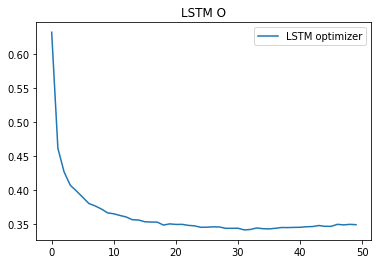

In [ ]:
plt.plot(model.training_losses, label='LSTM optimizer')
plt.legend()
plt.title("LSTM O")

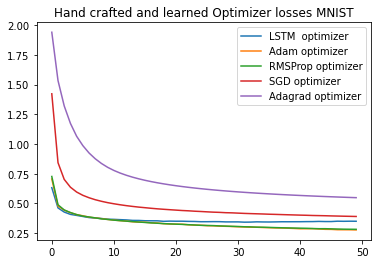

In [ ]:
plt.plot(model.training_losses, label='LSTM  optimizer')
plt.plot(adam_history.history['loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['loss'], label='Adagrad optimizer')

plt.title('Hand crafted and learned Optimizer losses MNIST')
# show a legend on the plot
plt.legend()

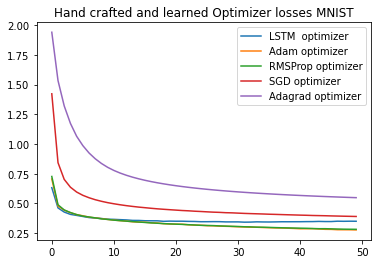

In [ ]:
plt.plot(model.training_losses, label='LSTM  optimizer')
plt.plot(adam_history.history['loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['loss'], label='Adagrad optimizer')

plt.title('Hand crafted and learned Optimizer losses MNIST')
# show a legend on the plot
plt.legend()

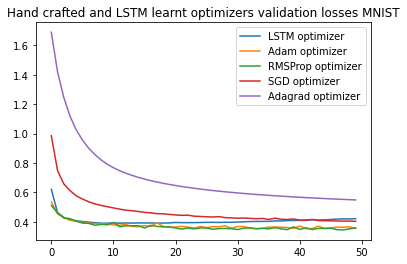

In [ ]:
# plt.plot(model.training_losses)
plt.plot(model.validation_losses, label='LSTM optimizer')
plt.plot(adam_history.history['val_loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['val_loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['val_loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['val_loss'], label='Adagrad optimizer')

plt.title('Hand crafted and LSTM learnt optimizers validation losses MNIST')
# show a legend on the plot
plt.legend()

## Accuracy

In [ ]:
def print_accuracy_report(optimizer_name, test_y, preds):
    print(f"***** {optimizer_name} Accuracy metrics******")
    print(sm.classification_report(test_y, preds, target_names=class_names))
    print()

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_report("LSTM_optimizer", test_y, np.argmax(lstm_optimizer_preds, axis=1))
print_accuracy_report("Adagrad", test_y, np.argmax(adagrad_preds, axis=1))
print_accuracy_report("RMSProp", test_y, np.argmax(rms_preds, axis=1))
print_accuracy_report("ADAM", test_y, np.argmax(adam_preds, axis=1))
print_accuracy_report("SGD", test_y, np.argmax(sgd_preds, axis=1))

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.81      0.81      0.81      1000
 Trouser/pants       0.98      0.95      0.97      1000
Pullover shirt       0.77      0.72      0.75      1000
         Dress       0.86      0.85      0.86      1000
          Coat       0.70      0.83      0.76      1000
        Sandal       0.89      0.94      0.91      1000
         Shirt       0.68      0.56      0.61      1000
       Sneaker       0.93      0.93      0.93      1000
           Bag       0.89      0.94      0.92      1000
    Ankle boot       0.95      0.93      0.94      1000

      accuracy                           0.85     10000
     macro avg       0.85      0.85      0.84     10000
  weighted avg       0.85      0.85      0.84     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.76      0.80      0.78      1000
 Trouser/pants    